In [14]:
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm 1 + 2 - Abnormal Price Detection
# Created By  : Eungi Cho
# Created Date: 07/06/22
# Updated Date: 22/06/22
# version = 2.0
# ---------------------------------------------------------------------------
# https://stats.stackexchange.com/questions/524673/confidence-interval-for-centered-moving-average-of-timeseries-data-smoothing

'''
Import pandas, numpy, matplotlib to analyze data
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

'''
Import warnings module to ignore the future warning messages
'''
import warnings
warnings.filterwarnings("ignore")

'''
Import KNNImputer module to impute missing values
'''
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


'''
import time measurement module to track the progress
'''
from tqdm import tqdm
tqdm.pandas()

In [2]:
'''
Load data from provided csv file
'''
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
df_raw = df_raw.drop_duplicates()
df_raw.head()

,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,16,China,2344,125,118227410,CNY,kg,2022-02-21,8.16,8.34,8.205000
1,16,China,2344,125,118227410,CNY,kg,2022-05-23,6.02,6.30,6.146667
2,16,China,2344,125,118227410,CNY,kg,2022-04-04,6.67,7.04,6.901667
3,16,China,2344,125,118227410,CNY,kg,2022-05-09,5.93,6.30,6.098000
4,16,China,2344,125,118227410,CNY,kg,2022-05-16,6.02,6.12,6.070000


# Data Pre-processsing
Step1: Randomly sampling 10000 entries to create 'sample_entry' (pd.DataFrame)

Step2: Join 'time_df' to each 'sample_entry', and make 'df' to reflect the actual frequency of price acquisition (W-MON)

Step3: Use KNN imputer to impute the null value of 'df', and update 'df'

In [3]:
'''
Randomly select 10,000 entries from df_raw to reduce processing time
'''

entry_lst = np.sort(df_raw['entry_id'].unique())
np.random.seed(0)
sample_entry = list(np.random.choice(entry_lst, 100))
sample_entry.extend([86615740, 86645377, 86665186, 86667725, 89728363, 86670906, 86634750, 86747768])
'''
Sort df_raw by values ['entry_id', 'date'] and name it as 'sample_df'  
'''
sample_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['entry_id', 'date']).copy()

'''
Change dtype of column 'date' to pd.Timestamp
'''
sample_df['date'] = pd.to_datetime(sample_df['date'])

In [4]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
'''
*** IMPORTANT ***
df_raw has the CHARACTERISTICS as below:
1) Frequency of price acquisition is every Monday (W-MON)
2) Column 'date' is a series of 'acquired dates'
   , that means it doesn't contain 'not acquired dates'.

Therefore, it needs a process to contain 'not acquired dates' in df_raw as well, 
for reflecting the 'actual' acquisition frequency by each entry.
'''

'''
Create empty dataframe first.
'''
empty_df = pd.DataFrame()
for entry in tqdm(sample_entry):
    '''
    Step 1: Find the first acquisition date (entry_start) by each entry
            , and create date timeseries range from {entry_start} to '2022-06-20'.
            ('2022-06-20' is used only for analysis)
    '''
    entry_start = min(sample_df.loc[sample_df['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-06-06', freq = 'W-MON')
    
    '''
    Step 2: Create 'time_df', and attach one column 'entry_id_'.
    '''
    time_df = pd.DataFrame({'date': date_range})
    time_df['entry_id_'] = entry
    
    '''
    Step 3: Left join 'time_df' to create 'joined_df', and append it to the 'empty_df'.
    '''
    entry_df = sample_df.loc[sample_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

empty_df = empty_df.drop(['entry_id'], axis = 1)

'''
Copy the result (empty_df) as 'df'
'''
df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
df.head()

100%|███████████████████████████████████████████████| 108/108 [00:02<00:00, 50.65it/s]


,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg
0,2020-01-06,40867745,39.0,India,1484.0,206.0,INR,kg,61.75,61.75,61.75
1,2020-01-13,40867745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-20,40867745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,40867745,39.0,India,1484.0,206.0,INR,kg,46.05,51.00,48.50
4,2020-02-03,40867745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def knn_impute_price(Series):
    '''
    The function is defined to impute the null values of price_avg.
    
    Two features are used when doing imputation:
    1) price acquisition date (column 'date' in df)
    2) price avg (column 'price_avg' in df)
    
    The function is used in 'groupby' method, to add results to the column as below:
        df['columnA'] = df.groupby('columnB').apply(knn_impute_price).
    
    Return: 
        imputed prices series by each entry_id
    '''
    
    imputer = KNNImputer(n_neighbors = 2)
    
    '''
    imputed: dtype = ndarray
    columns: 1st column = date, 2nd column = price_avg_imputed
    '''
    imputed = imputer.fit_transform(Series)[:, 1]
    imputed_price_series = pd.Series(imputed, index = Series.index)
    return imputed_price_series

'''
Change column 'date' dtype to category, and save it to new column 'date_category'
'''
df['date_category'] = df['date'].astype('category').cat.codes

'''
Add new column 'price_avg_imputed' as a result of knn_impute_price.

ref:
    groupby method here returns series with multiple index. 
    So drop one of them ('entry_id_') for matching the index with index of the df.
'''

df['price_avg_imputed'] = df.groupby(by = 'entry_id_').progress_apply(
    lambda df: knn_impute_price(df[['date_category', 'price_avg']])
).reset_index().set_index('level_1').drop('entry_id_', axis=1)

100%|██████████████████████████████████████████████| 108/108 [00:00<00:00, 233.66it/s]


In [6]:
'''
df_stats contains only essential features from df.
'''
df_stats = df[['date', 'entry_id_', 'price_avg', 'price_avg_imputed']].copy()
df_stats_pivot = df_stats.pivot_table(['price_avg', 'price_avg_imputed']
                          , index = ['entry_id_'], columns = ['date']
                          , dropna = False)

In [8]:
def abnormalDetection_by_entry(df_pivot, entry_id, sigma=2, window = 4, display_plot = False):
    '''
    This function is defined to get a list of abnormal prices & plot trend of price by each entry.
    
    Only applied to a single entry. So must input an entry_id when using this function.
    
    # Return two List: 
    # 1) series of dates when abnormal prices were detected
    # 2) list of abnormal prices
    '''
    # price_avg & price_avg_imputed
    # x axis = 'date', y axis = 'price_avg' or 'price_avg_imputed'
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry['date']
    y = sample_entry['price_avg'].astype(np.double)
    y_imputed = sample_entry['price_avg_imputed'].astype(np.double)    
    
    # trend_line(Moving Average Line) & Confidence bands
    sample_entry['moving_avg'] = sample_entry['price_avg_imputed'].rolling(min_periods = 1, window = window).mean()
    sample_entry['moving_avg_shift'] = sample_entry['moving_avg'].shift(1)
    sample_entry['moving_avg_shift'] = sample_entry['moving_avg_shift'].fillna(sample_entry['moving_avg'])
    trend_line = sample_entry['moving_avg_shift']
    
    # Standardization
    Z_y = (y - y.mean()) / y.std() if ((y - y.mean()) / y.std()).isnull().sum() != len(y) else ((y - y.mean()) / y.std()).replace(np.nan, 0)
    Z_y_imputed = (y_imputed - y.mean()) / y.std() if ((y_imputed - y.mean()) / y.std()).isnull().sum() != len(y) else ((y_imputed - y.mean()) / y.std()).replace(np.nan, 0)
    Z_trend_line = (trend_line - trend_line.mean()) / trend_line.std() if ((trend_line - trend_line.mean()) / trend_line.std()).isnull().sum() != len(y) else ((trend_line - trend_line.mean()) / trend_line.std()).replace(np.nan, 0)
    upper_band = Z_trend_line + sigma
    lower_band = Z_trend_line - sigma
    
    # Outlier detection
    x_idx_lst = []
    outlier_prices = []
    
    for i in range(len(Z_y)):
        if  Z_y[i] > upper_band[i] or Z_y[i] < lower_band[i]:
            x_idx_lst.append(i)
            outlier_prices.append(y[i])
    
    outlier_date = x[x_idx_lst]
    Z_y_outlier = np.where(Z_y.index.isin(x_idx_lst), Z_y, np.nan)
    
    # Display_plot
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        plt.plot(x, Z_y, linestyle = '-', marker = 'o', color = '#5FBA09', markersize = 5)
        plt.plot(x, Z_y_imputed, linestyle = '--', marker = 'x', color = '#5FBA09', alpha = 0.5, markersize = 5)
        plt.plot(x, Z_trend_line, color = '#ff9933')
        plt.plot(x, upper_band, '--', color='#ff0000')
        plt.plot(x, lower_band, '--', color='#ff0000')
        plt.plot(x, Z_y_outlier, 'o'
            , markersize = 12, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2)
        plt.xticks(x, rotation = 90)
        plt.title(f'entry_id: {entry_id}, window: {window}, sigma: {sigma}')

        # axvspan with red color - find index of start & end point of null in price_avg
        sample_entry = sample_entry.set_index('date')
        is_nan = sample_entry['price_avg'].isna()
        n_groups = is_nan.ne(is_nan.shift()).cumsum()

        if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
            gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
                lambda x: (
                    x.index[0] + pd.DateOffset(days=-7),
                    x.index[-1] + pd.DateOffset(days=+7)
                )
            )['price_avg'].values

            for gap in gap_list:
                plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)

        plt.show()

    return outlier_date, outlier_prices

def calculate_statistics_and_alarm(df):
    '''
    This function is used in two ways:
    1) Add statistics results of 'price_avg' as columns in DataFrame
    2) Detect abnormal prices and raise alarm if price exceeds confidence band (alarm True = 1, False = 0)
    
    Return pd.DataFrame
    
    *** IMPORTANT ***
    Use (n-1)th 'Z_moving_avg' to evaluate (n)th 'Z_price'
        IF 'Z_price' > 'Z_moving_avg' + 2 (upper band)
        OR 'Z_price' < 'Z_moving_avg' - 2 (lower band)
        Raise Alarm    
    '''
    df['moving_avg'] = df.groupby('entry_id_')['price_avg_imputed'].rolling(window = 4, min_periods = 1).mean().reset_index(0, drop=True)
    df['moving_avg_shift'] = df.groupby('entry_id_')['moving_avg'].shift(1)
    df['moving_avg_shift'] = df['moving_avg_shift'].fillna(df['moving_avg'])
    
    
    
    '''
    If std() == 0, standardization would return np.nan.
        If totally same prices have been acquired throughout the whole periods, then std() would be 0
    In this case, we should set 'Z_price' and 'Z_moving_avg' as 0, and not np.nan
    '''
    df['Z_price'] = df.groupby('entry_id_')['price_avg'].apply(lambda series : (series - series.mean()) / series.std() 
                                                               if ((series - series.mean()) / series.std()).isnull().sum() != len(series) 
                                                               else ((series - series.mean()) / series.std()).replace(np.nan, 0))
    df['Z_moving_avg'] = df.groupby('entry_id_')['moving_avg_shift'].apply(lambda series : (series - series.mean()) / series.std() 
                                                                           if ((series - series.mean()) / series.std()).isnull().sum() != len(series) 
                                                                           else ((series - series.mean()) / series.std()).replace(np.nan, 0))
    df['Z_upper_band'] = df.groupby('entry_id_')['Z_moving_avg'].apply(lambda series : series + 2)
    df['Z_lower_band'] = df.groupby('entry_id_')['Z_moving_avg'].apply(lambda series : series - 2)
    
    df['Alarm'] = np.where((
        df['Z_price'] > df['Z_upper_band']) | (
        df['Z_price'] < df['Z_lower_band'])
        , 1, 0)
    
    return df

In [9]:
%%timeit
calculate_statistics_and_alarm(df_stats)

227 ms ± 8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


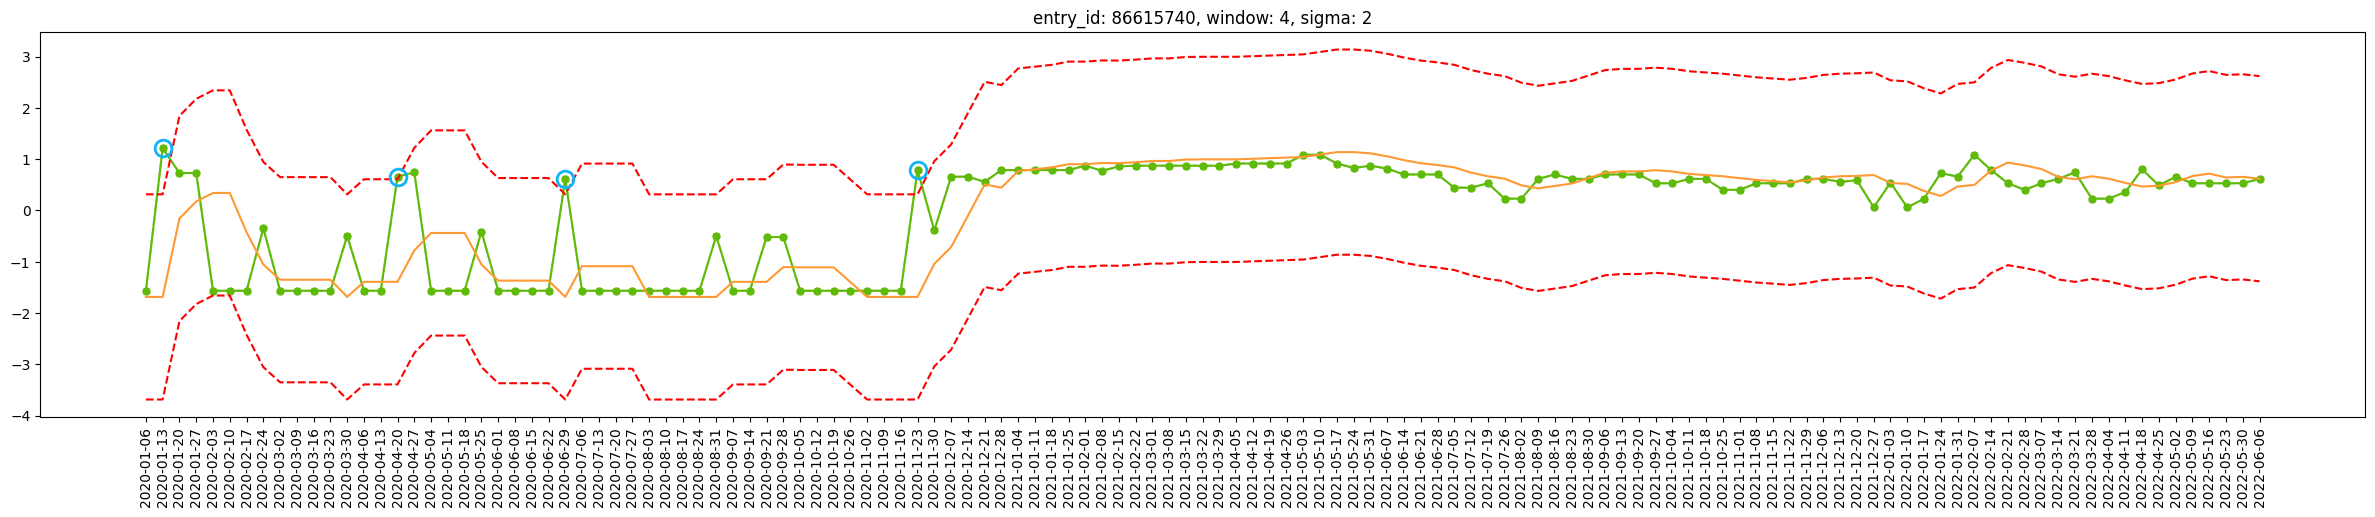

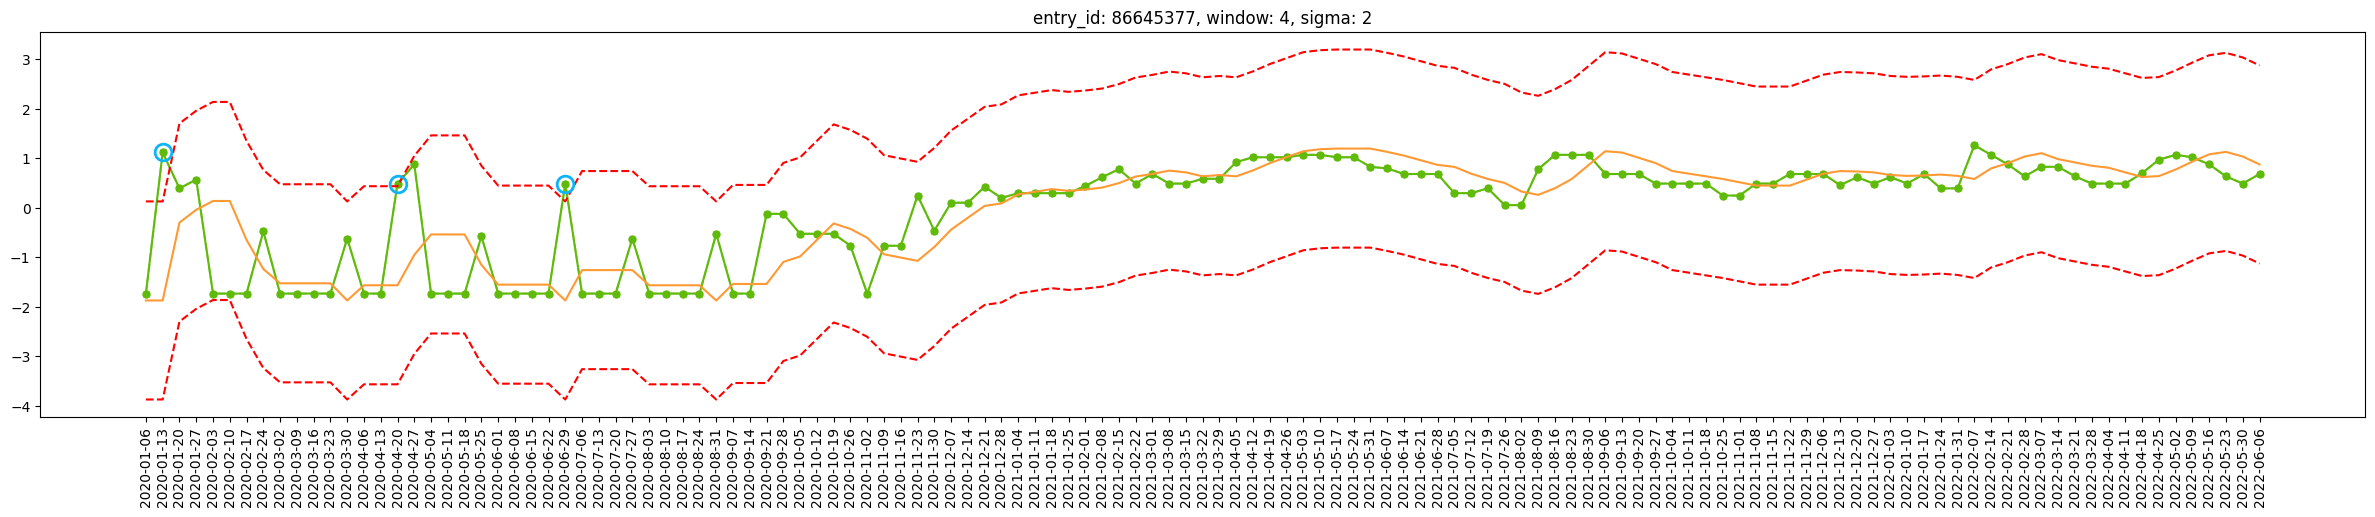

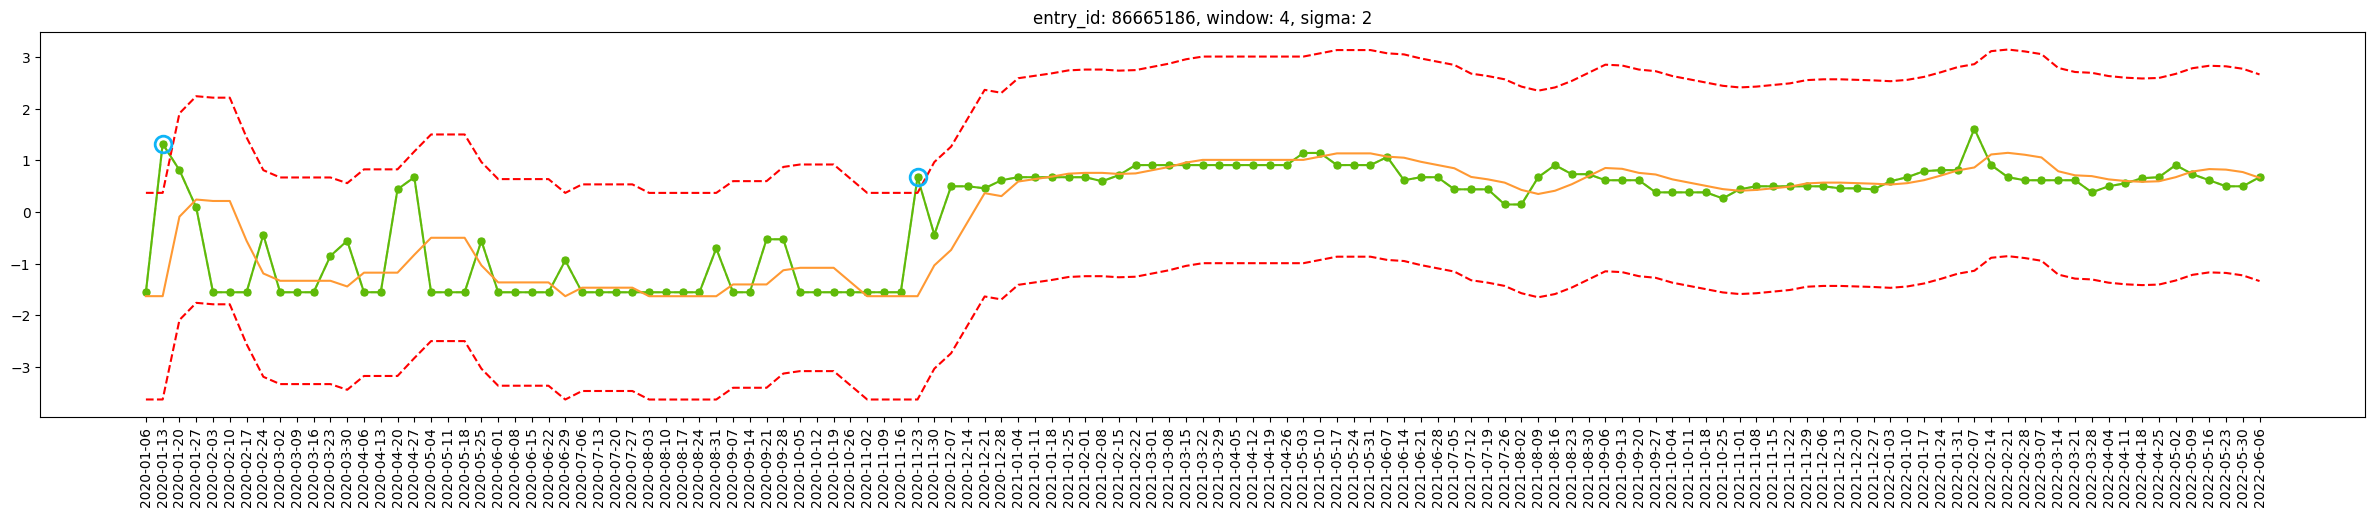

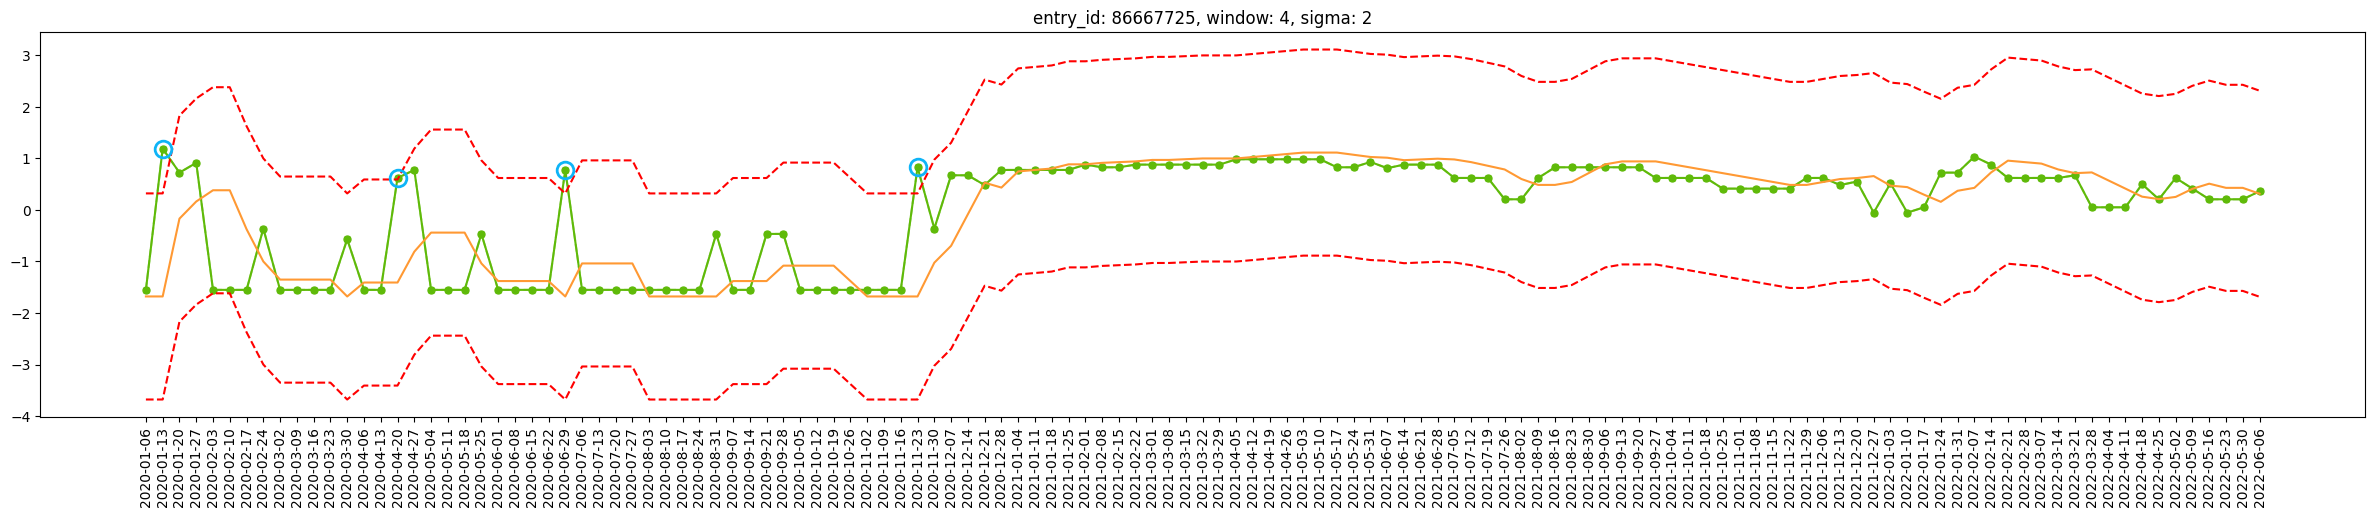

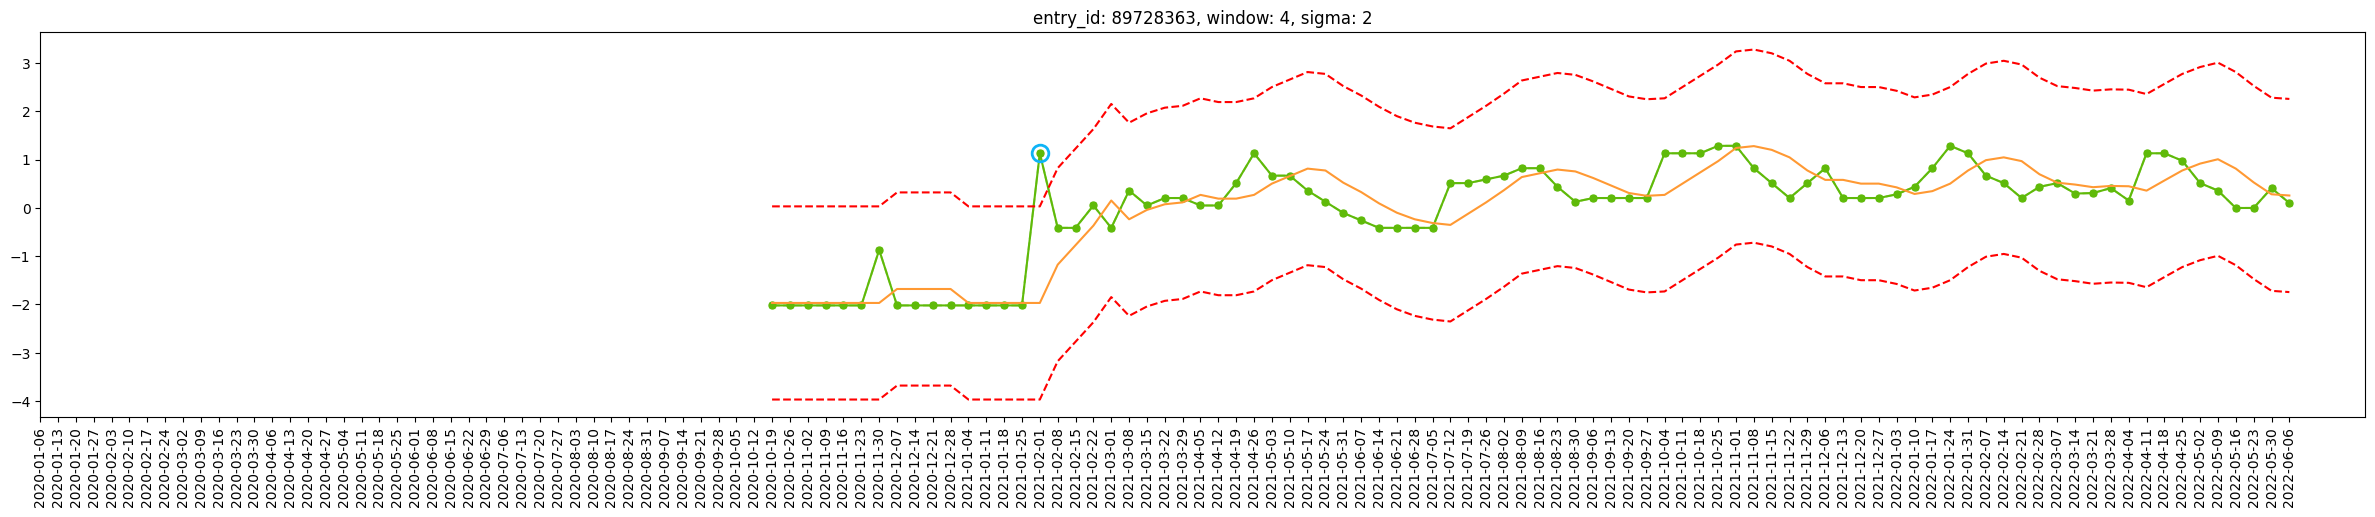

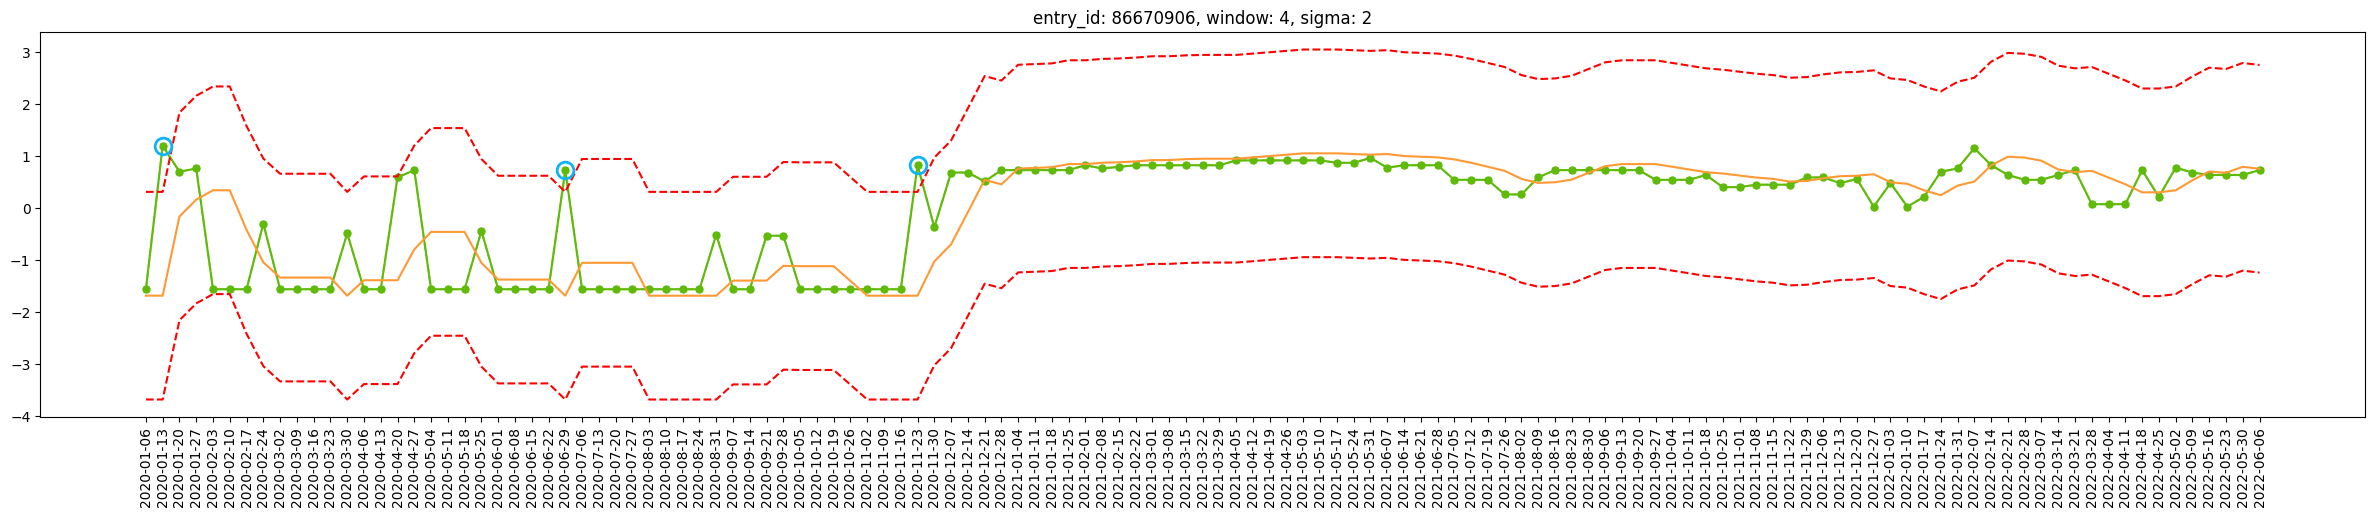

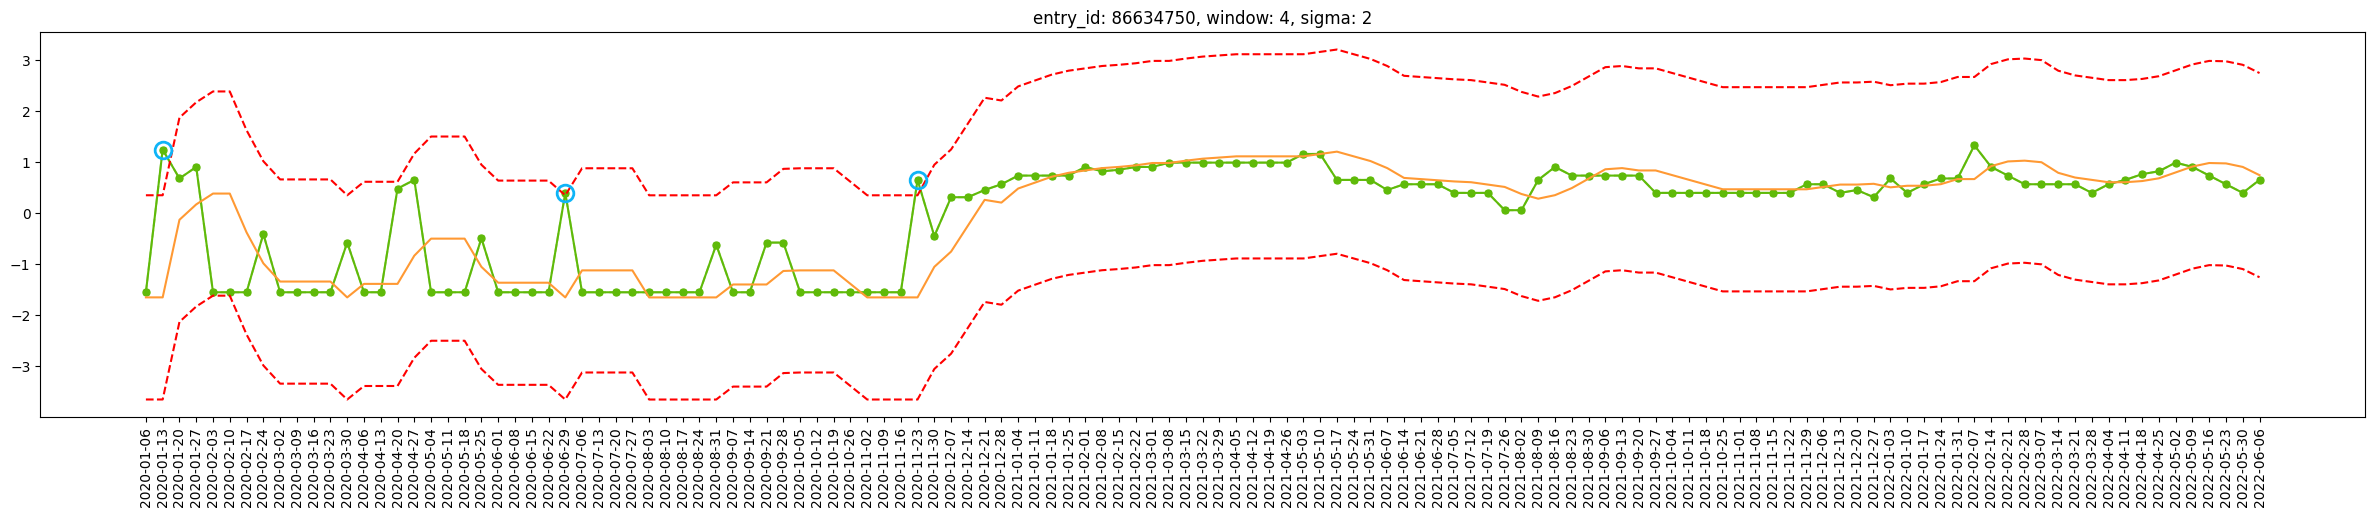

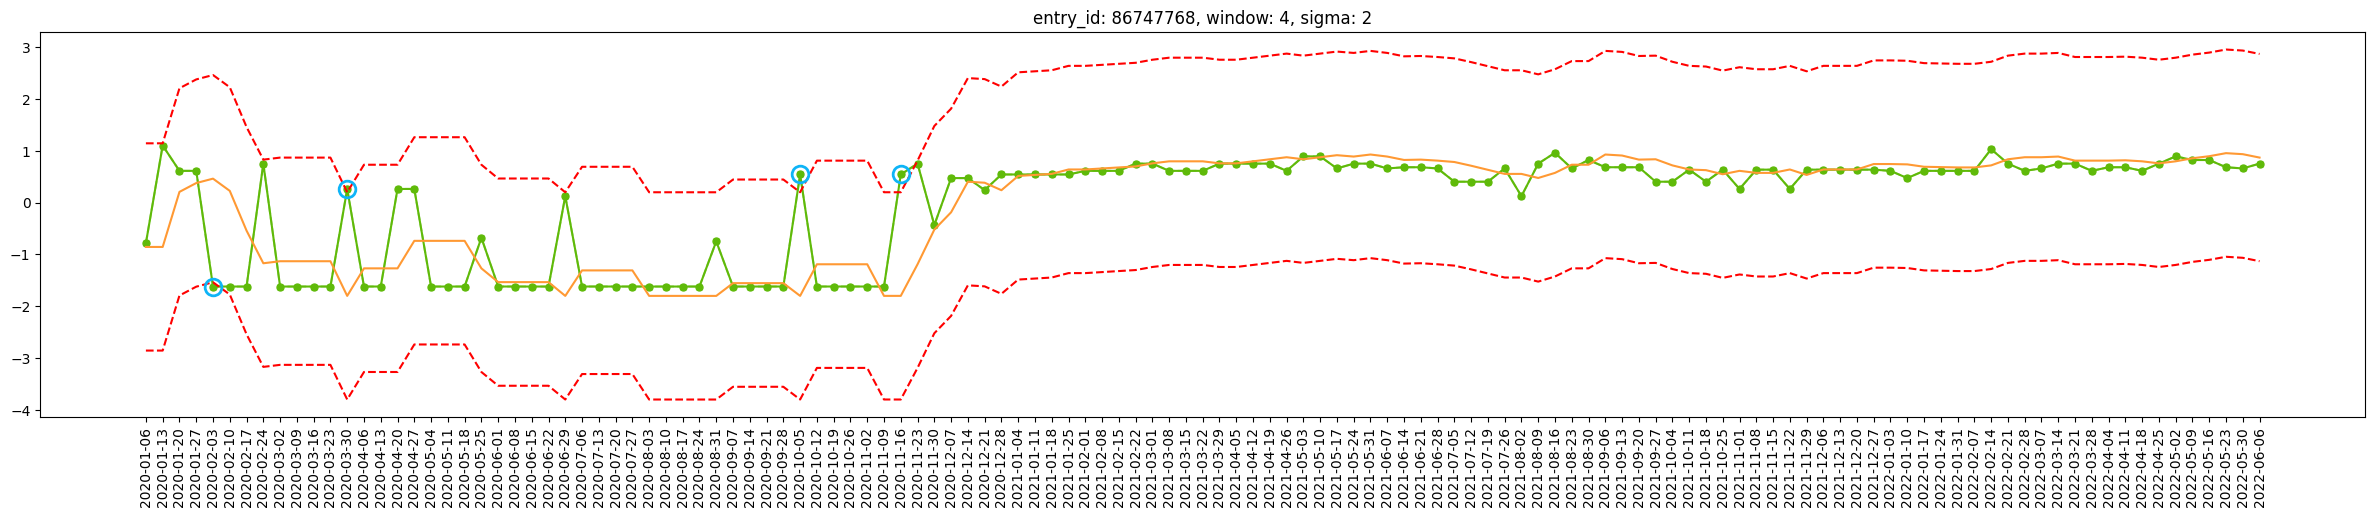

In [13]:
'''
sample here is an entry_id that we select as a sample
'''

samples = [86615740, 86645377, 86665186, 86667725, 89728363, 86670906, 86634750, 86747768]
# df_stats.loc[(df_stats.entry_id_ == sample) & (df_stats.Alarm == 1)]

for sample in samples:
    outlier_date, outlier_prices = abnormalDetection_by_entry(
                                            df_pivot = df_stats_pivot, entry_id = sample
                                            , sigma = 2, window = 4
                                            , display_plot = True
                                   )
    print(f'outlier_date: {np.array(outlier_date.values)}')
    print(f'outlier_prices: {outlier_prices}')

In [16]:
scaler = MinMaxScaler()
def min_max_scaling_original(df_pivot, entry_id, sigma=2, display_plot = False):
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    to_scale = sample_entry[['price_avg', 'price_avg_imputed']]
    scaler.fit(to_scale)
    sample_entry_scaled = scaler.transform(to_scale)
    sample_entry_scaled_df = pd.DataFrame(sample_entry_scaled, columns = to_scale.columns)
    sample_entry_scaled_df = pd.concat([sample_entry_scaled_df, sample_entry['date']], axis = 1)
    sample_entry_scaled_df.set_index('date', inplace=True)
    
    x = sample_entry_scaled_df.index
    y = sample_entry_scaled_df['price_avg'].astype(np.double)
    y_imputed = sample_entry_scaled_df['price_avg_imputed'].astype(np.double)
    
    window_size = 8
    def calculate_lower_upper_band(series, df):
        
        average = []
        upper_band = []
        lower_band = []
        
        # maintain its original index
        not_null_series = series[~np.isnan(series.values)]
        
        # Initialize parameters 
        i = 0
        start = 0
        while i < len(not_null_series) - window_size + 1:
            if (not_null_series.index[i + window_size - 1] - not_null_series.index[start]) / np.timedelta64(1, 'M') > 6:
                start += 1
                        
            window = not_null_series[start : i + window_size]
            upper = sigma * window.std() + window.mean()
            lower = -sigma * window.std() + window.mean()
            
#             if start != 0:
#                 print(f'{not_null_series.index[start]} ~ {not_null_series.index[i + window_size - 1]}: {window.mean()}, {window.std()}, {upper}')

            upper_band.append(upper)
            lower_band.append(lower)
            average.append(window.mean())

            i += 1
    
        band_df = pd.DataFrame({  
            'upper_band': upper_band, 
            'lower_band': lower_band,
            'average'   : average
            }, 
            index = not_null_series.index[window_size - 1 :]
        )
        df = pd.concat([df, band_df], axis = 1)
    
        return df
    
    sample_entry_scaled_df = calculate_lower_upper_band(y_imputed, sample_entry_scaled_df)
    sample_entry_scaled_df.to_excel('test.xlsx')
    
    # '''--------------------------'''
    # '''----------- Plot ------------ '''
    upper_band = sample_entry_scaled_df['upper_band'].shift(1)
    lower_band = sample_entry_scaled_df['lower_band'].shift(1)
    average_line = sample_entry_scaled_df['average'].shift(1)

    
    x_idx_lst = []
    outlier_lst = []
    for i in range(len(sample_entry_scaled_df)):
        if y[i] > upper_band[i] or y[i] < lower_band[i]:
            x_idx_lst.append(i)
            outlier_lst.append(y[i])
    
    outlier_date = x[x_idx_lst]
    y_outlier = np.where(y.index.isin(outlier_date), y, np.nan)
        
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        plt.plot(x, y, linestyle = '-', marker = 'o', color = '#5FBA09', markersize = 5)
        plt.plot(x, y_imputed, linestyle = '--', marker = '^', color = '#5FBA09', alpha = 0.5, markersize = 5)
        plt.plot(x, upper_band, '--', color='blue')
        plt.plot(x, lower_band, '--', color='#ff0000')
        plt.plot(x, y_outlier, 'o'
            , markersize = 12, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2)
        plt.plot(x, average_line, '--', color = 'grey')
        plt.xticks(x, rotation = 90)
        plt.title(f'entry_id: {entry_id}, sigma: {sigma}')

        # axvspan with red color - find index of start & end point of null
        sample_entry = sample_entry.set_index('date')
        is_nan = sample_entry['price_avg'].isna()
        n_groups = is_nan.ne(is_nan.shift()).cumsum()

        if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
            gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
                lambda x: (
                    x.index[0] + pd.DateOffset(days=-7),
                    x.index[-1] + pd.DateOffset(days=+7)
                )
            )['price_avg'].values

            for gap in gap_list:
                plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)

        plt.show()
        
    return x_idx_lst, outlier_date, outlier_lst

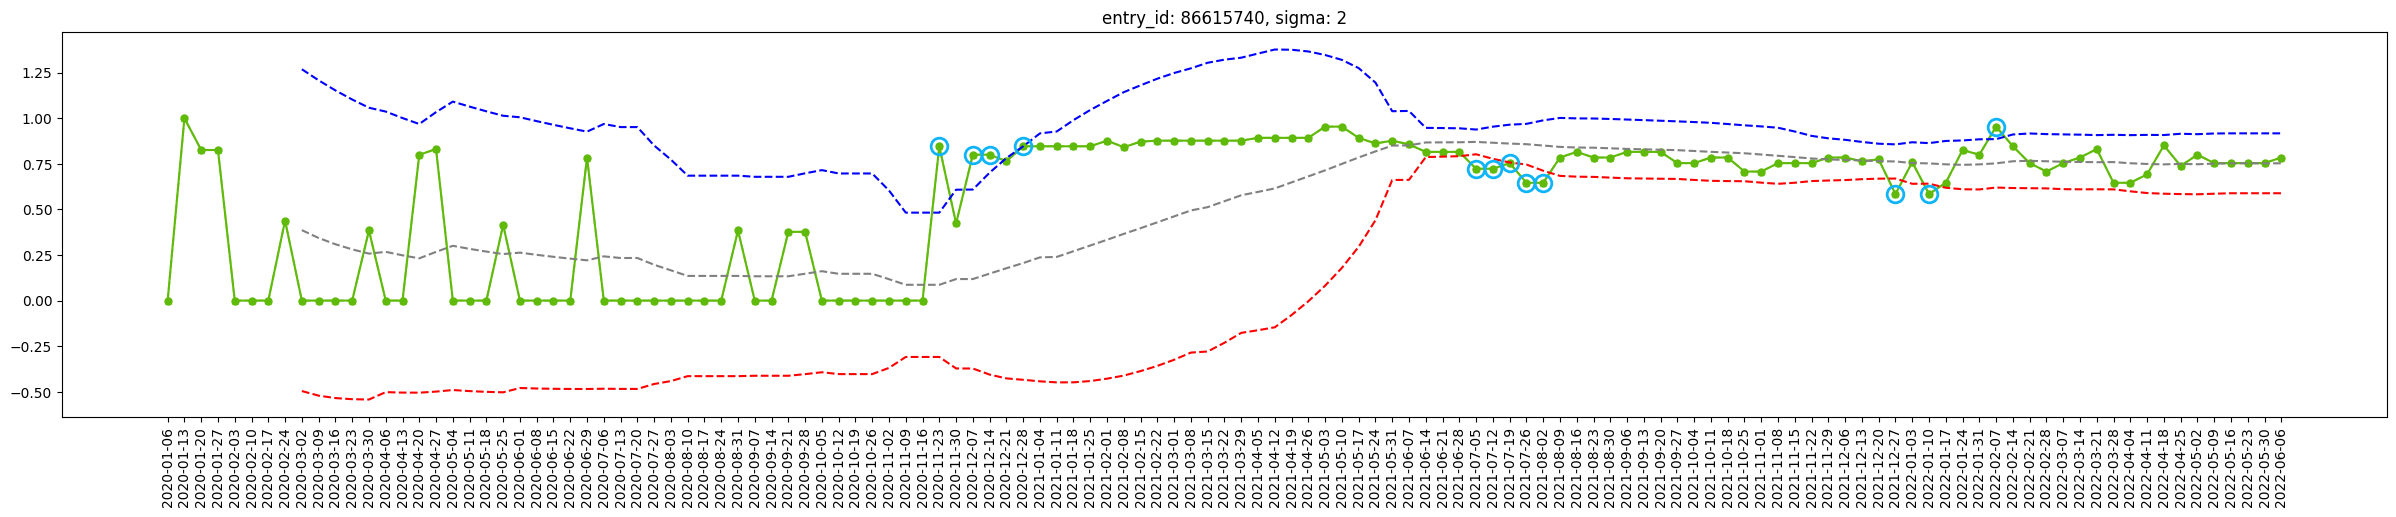

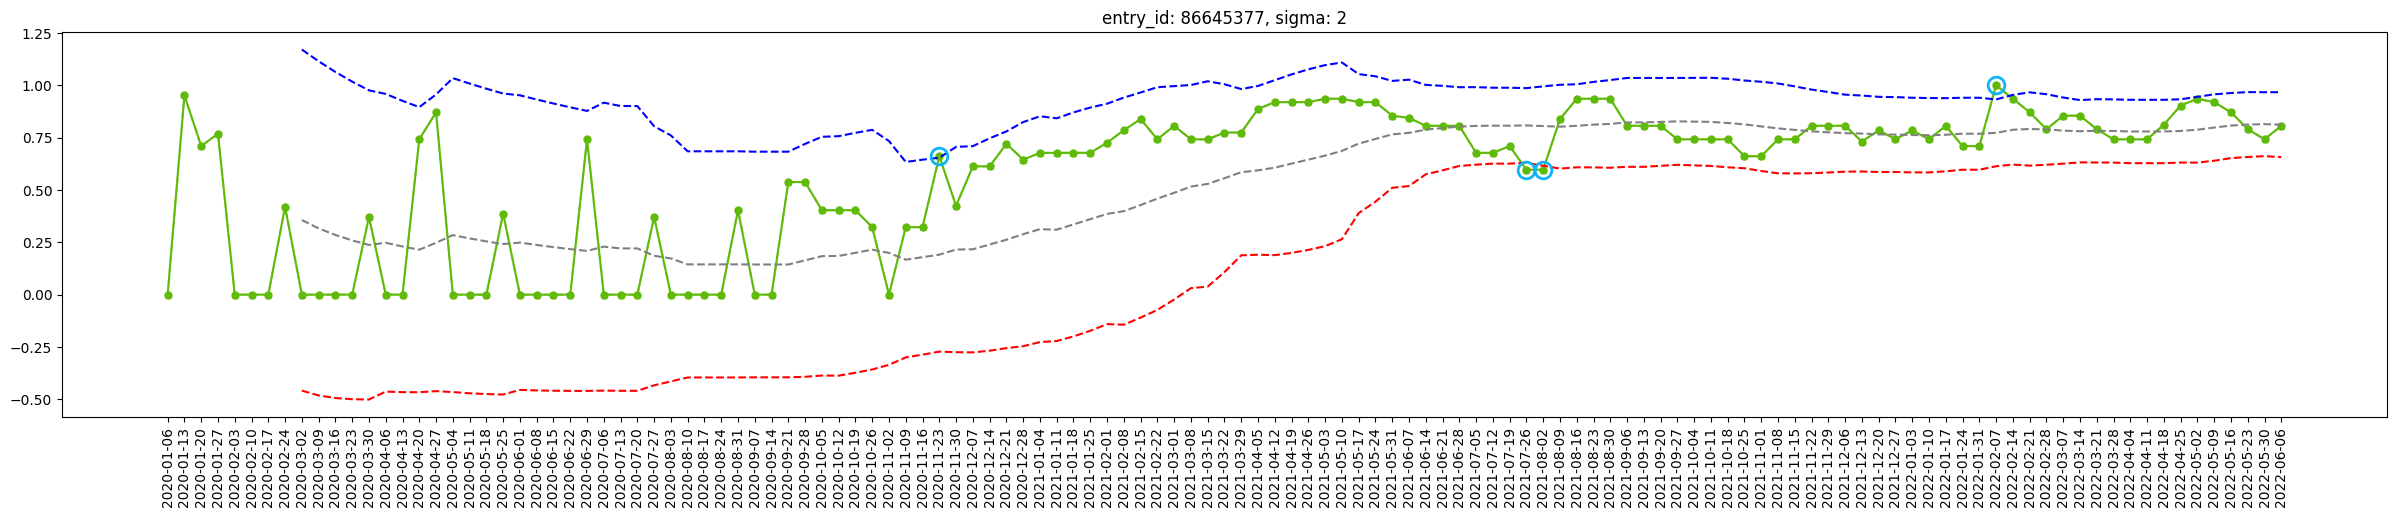

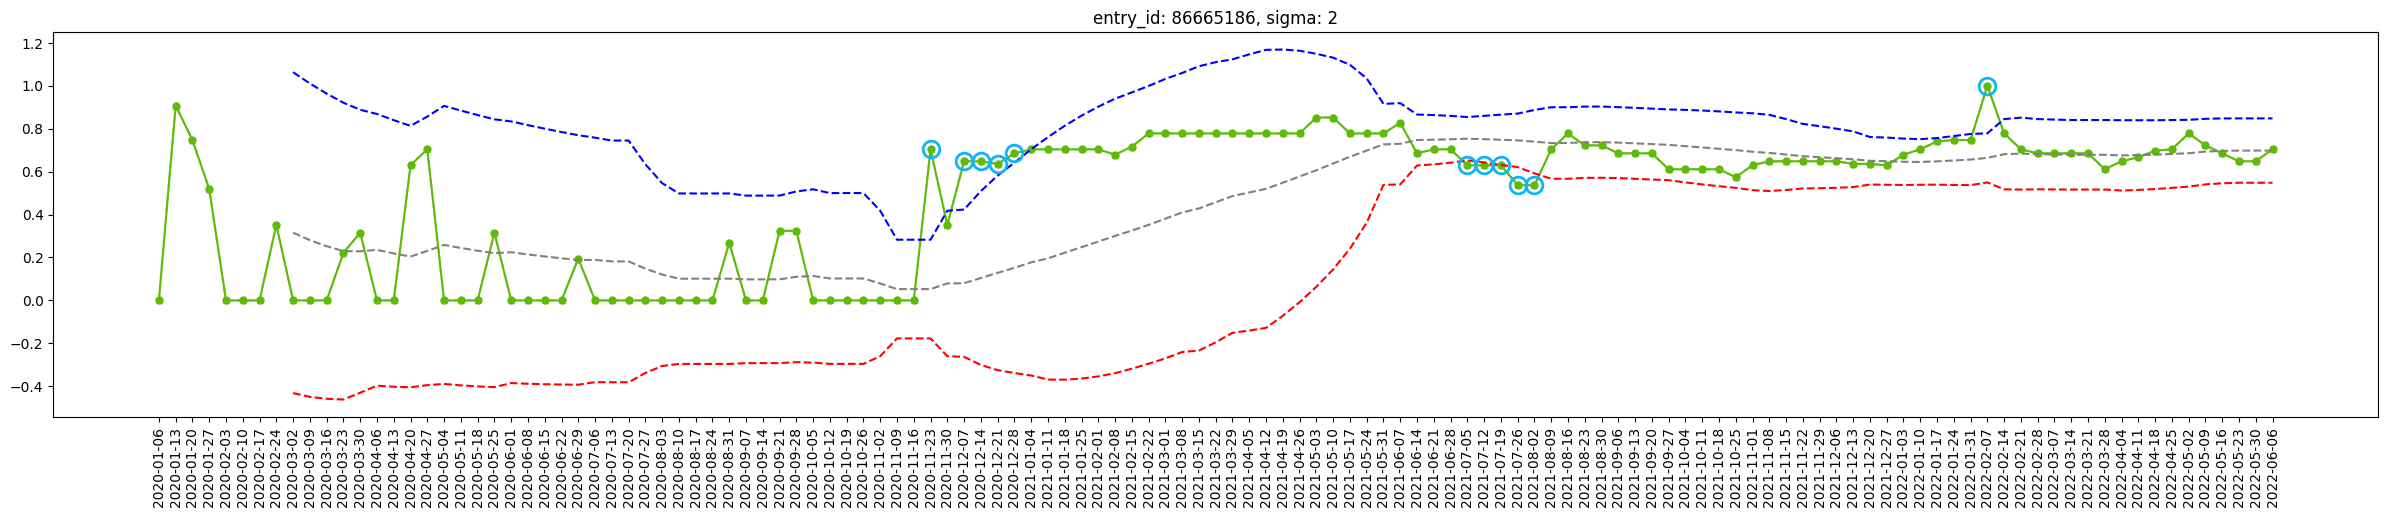

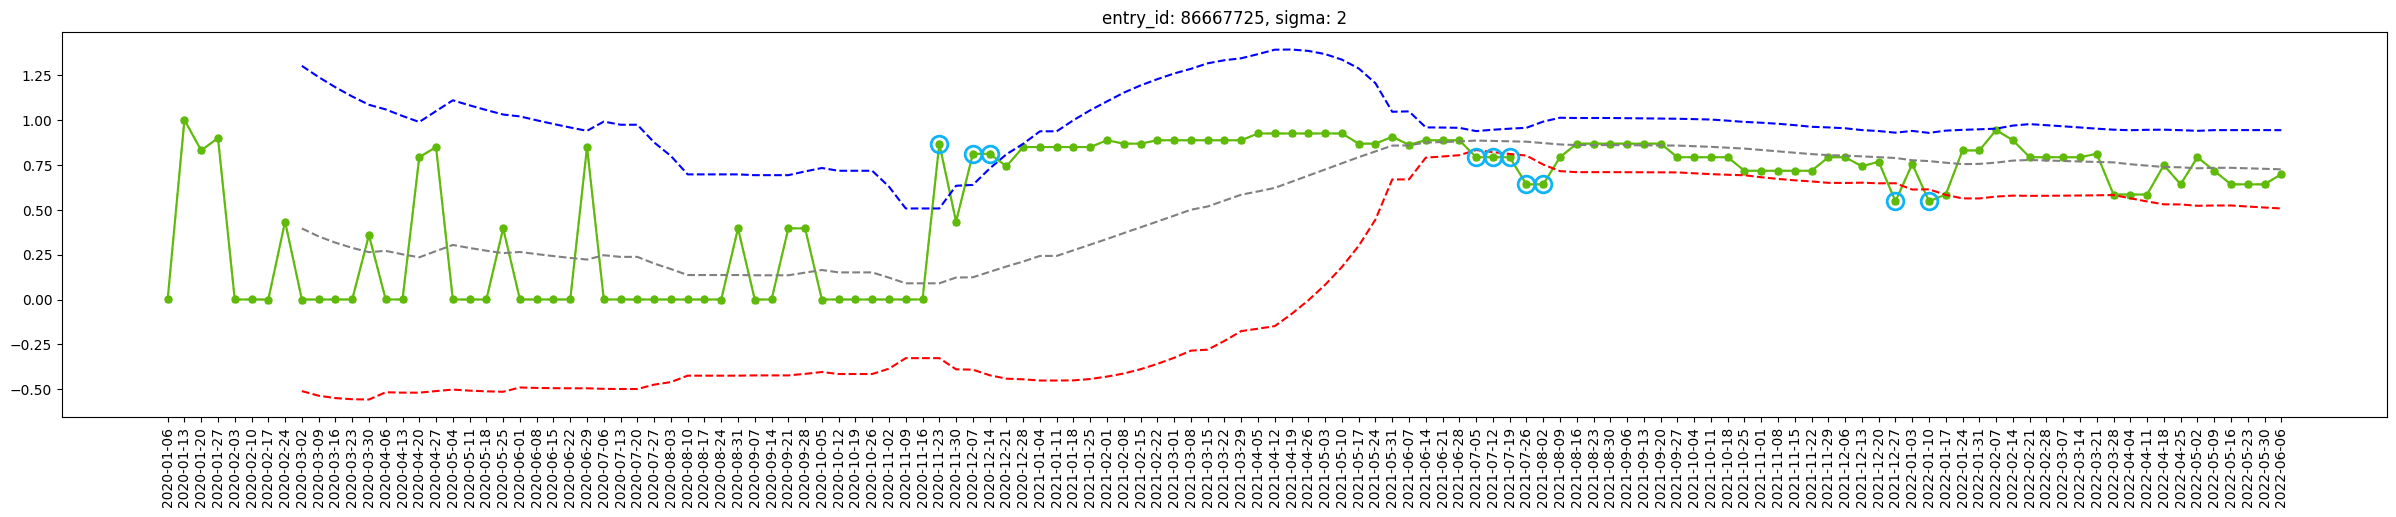

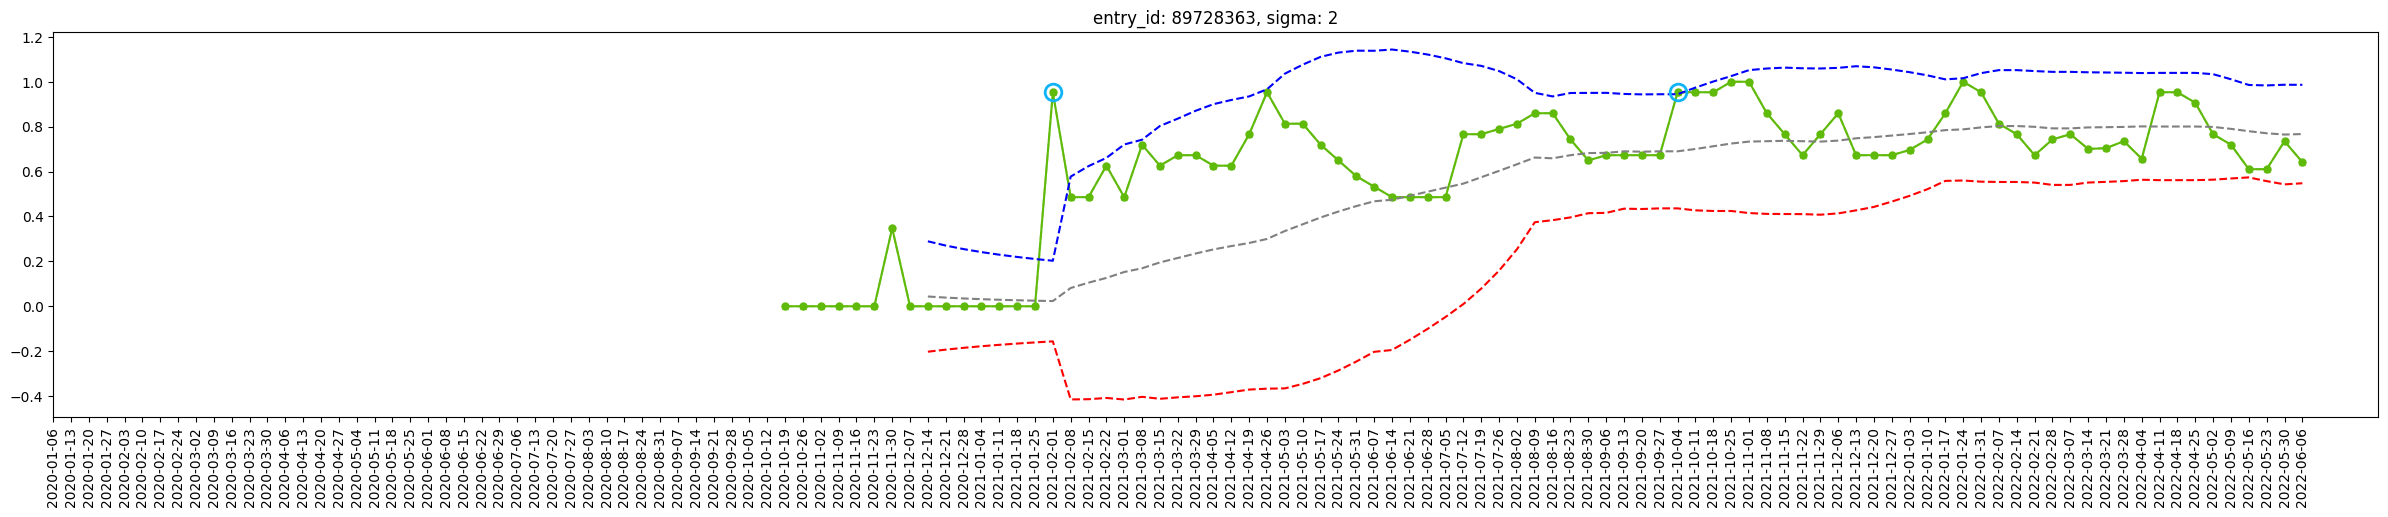

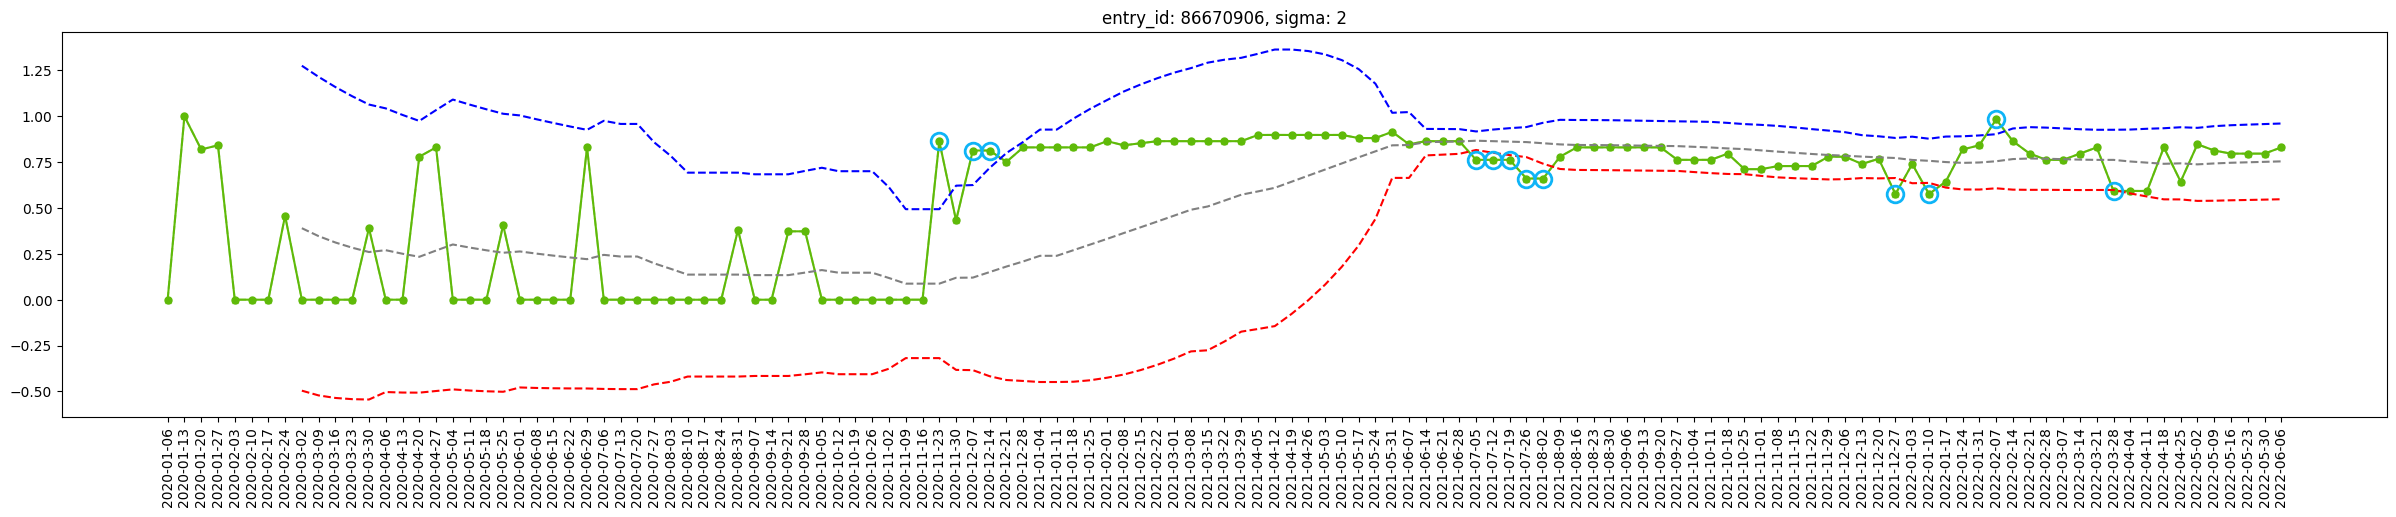

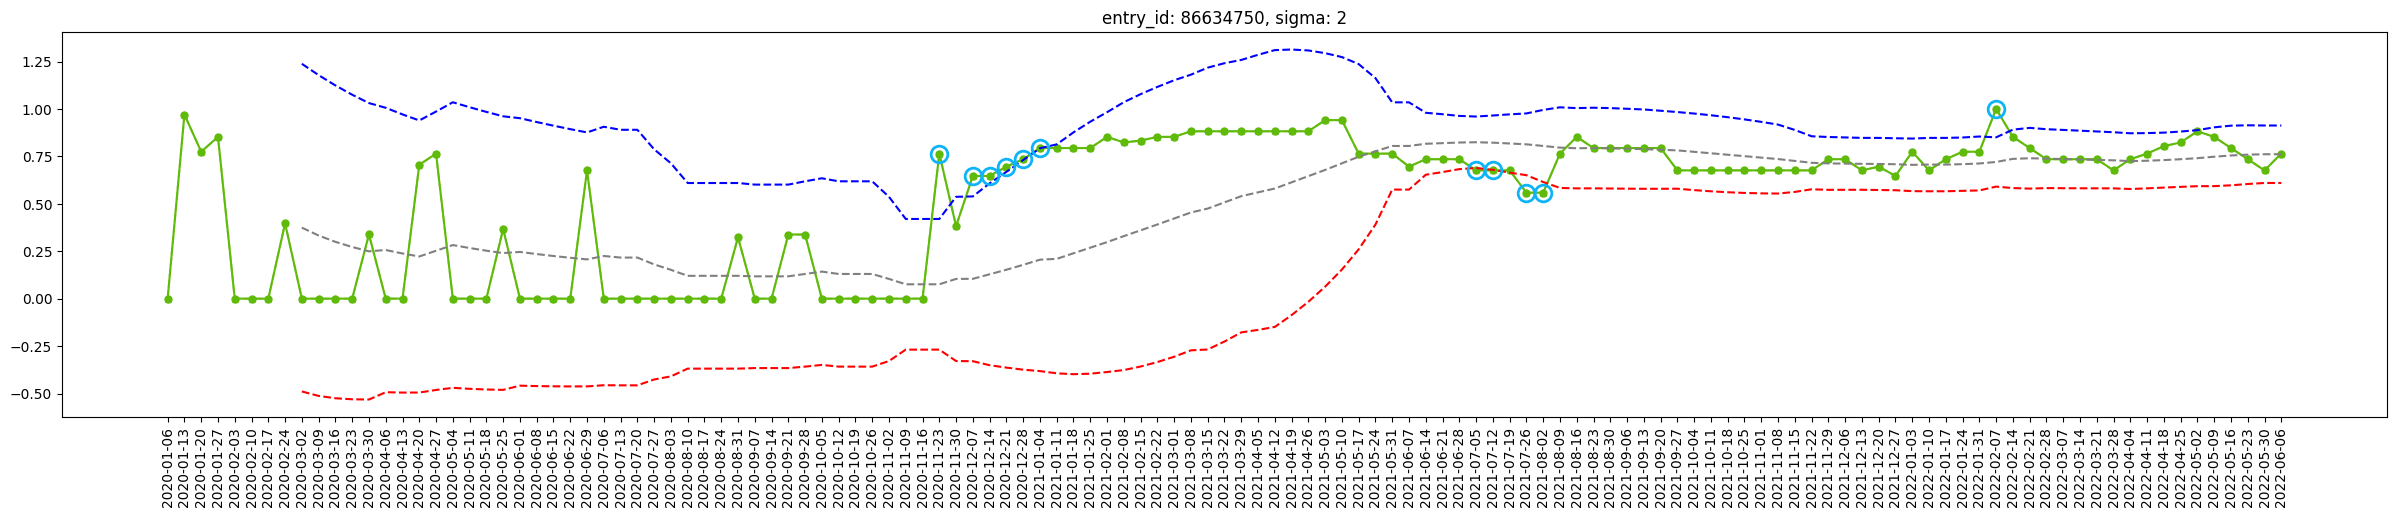

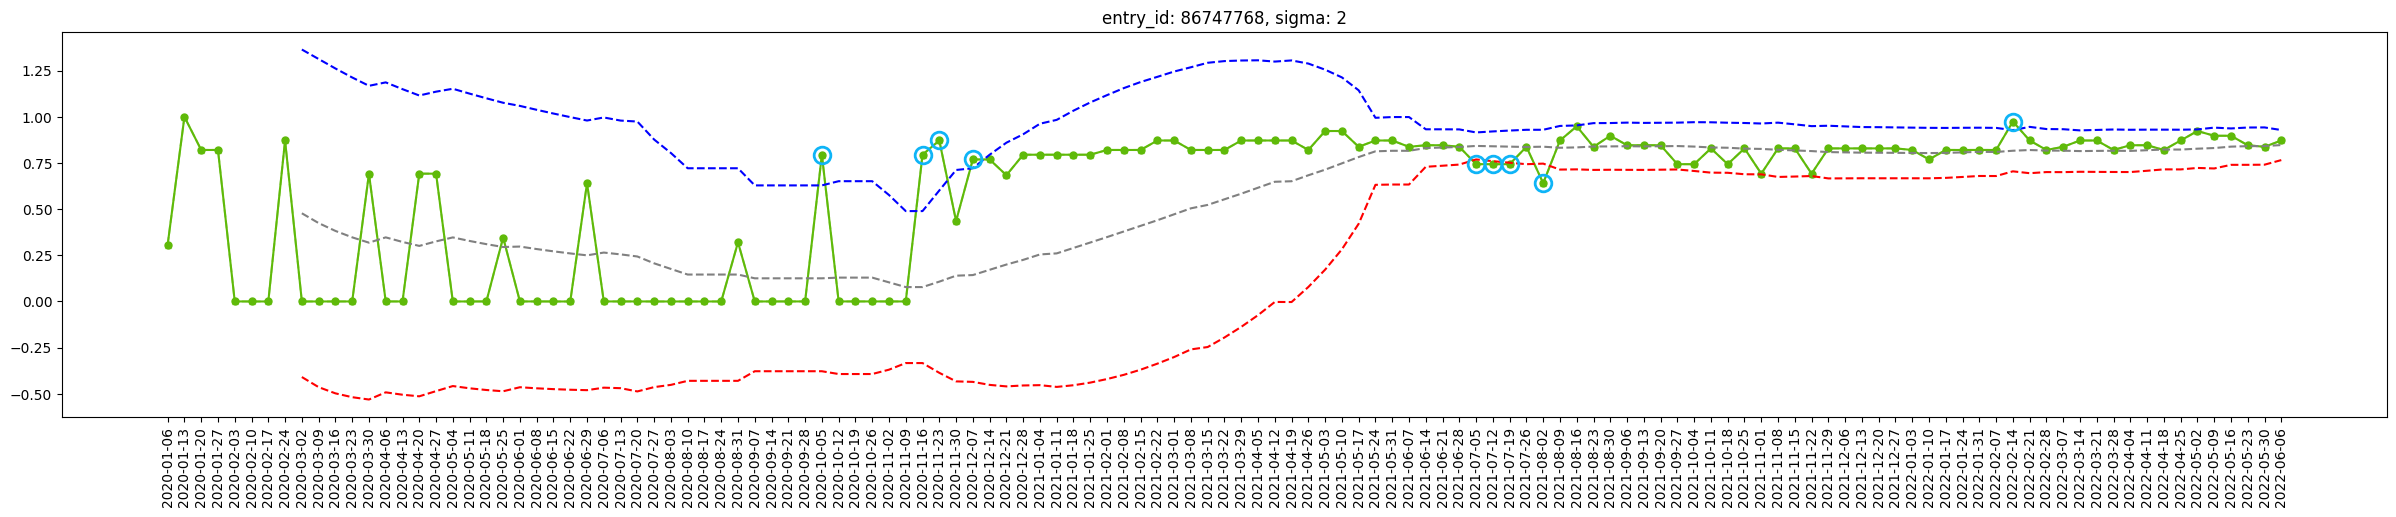

In [18]:
for sample in samples:
    min_max_scaling_original(df_pivot = df_stats_pivot, entry_id = sample, sigma = 2, display_plot = True)

# Replace historical data out of the orbit

- To reduce the False Alarm (False positive)

- Find the historical point which is thought to be outliers (price_avg), and replace those values to np.nan

- Then, impute with knn_imputer, and replace the original price_avg_imputed to new price_avg_imputed

- Finally, re-plot moving_average, see how the trend line was changed.

In [55]:
def replace_outlier_and_reimpute(df, entry_id, outlier_date):
    '''
    This function is used to replace the acquired price to imputed price.
    Prices of {entry_id} which were acquired at {outlier_date} would be replaced by KNN-imputed prices.
    
    Return pd.DataFrame
    
    *** IMPORTANT ***
    {outlier_date} must be Timestamp object.
    ex. pd.date_range(start = '2020-01-06', end = '2020-02-24', freq = 'W-MON')
    '''
    
    # Replace Outlier to np.nan
    df.loc[(df['entry_id_'] == entry_id) & (df['date'].isin(outlier_date)), 'price_avg'] = np.nan
    
    df['date_category'] = df_stats['date'].astype('category').cat.codes
    df['price_avg_imputed'] = df.groupby(by = 'entry_id_').progress_apply(
                                  lambda df: knn_impute_price(df[['date_category', 'price_avg']])
                              ).reset_index().set_index('level_1').drop('entry_id_', axis=1)
    return df

'''
Below is an example about changing all of the detected abnormal prices to imputed prices.
entry_id = 50895935
'''

outlier_date, outlier_prices = abnormalDetection_by_entry(
                                        df_pivot = df_stats_pivot, entry_id = sample
                                        , sigma = 2, window = 4
                               )

df_temp = df_stats.copy()
replace_outlier_and_reimpute(df = df_temp, entry_id = sample, outlier_date = outlier_date)

# Recalculate statistics again
calculate_statistics_and_alarm(df_temp)
df_temp.loc[(df_temp.entry_id_ == sample) & (df_temp.Alarm == 1)]

100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.97it/s]


,date,entry_id_,price_avg,price_avg_imputed,moving_avg,moving_avg_shift,Z_price,Z_moving_avg,Z_upper_band,Z_lower_band,Alarm,date_category


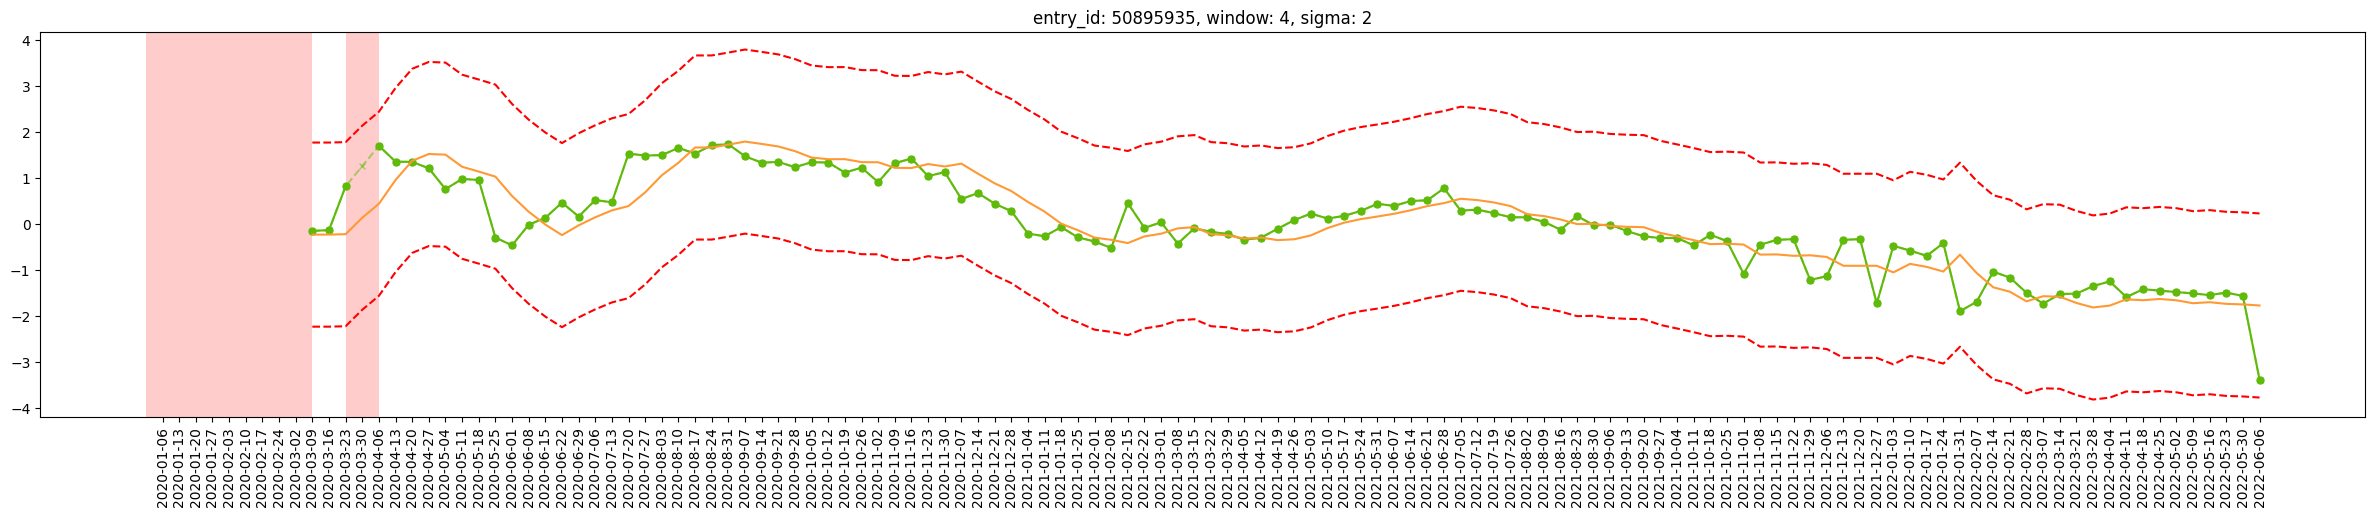

(Series([], Name: date, dtype: datetime64[ns]), [])

In [56]:
df_temp_pivot = df_temp.pivot_table(['price_avg', 'price_avg_imputed']
                          , index = ['entry_id_'], columns = ['date']
                          , dropna = False)

abnormalDetection_by_entry(df_pivot = df_temp_pivot
                                    , entry_id = sample, sigma = 2
                                    , window = 4, display_plot = True)